# S-wave scattering phase shifts

In [1]:
from scipy.integrate import odeint
from scipy.special import struve
from scipy.special import yn
from scipy.special import riccati_yn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.dpi'] = 130

In [3]:
hbar = 1.0545718e-34 # [Js]
eV = 1.602176634e-19 # [J]
meV = 1e-3 * eV
au = 10e-22 * eV # [(m/V)^-2]

angstrom = 1e-10
R = angstrom
r = np.linspace(0, 100, 1024) * angstrom # [m]

### Parameters form tables 1 and 2

In [4]:
# table 1.
r_0 = 44.6814 * angstrom # [m]
mass_e = 9.10938356e-31 # [kg]
mass_eff_e = 0.47 * mass_e 
mass_eff_h = 0.54  * mass_e
mass_X = mass_eff_e + mass_eff_h
M_red = mass_eff_e * mass_X / (mass_eff_e + mass_X) 

# table 2
r_star = 34 * angstrom # only symmetric phase shift
v_0 = -58.5 * meV
alpha = 52 *  10**3 * au 

In [5]:
E_min = 0.1 * meV
E_max = 60 * meV
E = np.linspace(E_min, E_max, 1024)
k = np.sqrt(2 * M_red * E) / hbar

# IV Electron-exciton scattering
### Variable Phase Approach for (Schmidt et al.)

In [6]:
# for scale analysis:
# r_0 = 44.6814 * angstrom # [m]
# au = 10e-22 * eV # [(m/V)^-2]
# v_0 = -58.5meV, alpha = 52 *  10**3 * au 

def keldysh(r):
    # equation (2)
    V_K = (np.pi / (2 * r_0) * (struve(0, r / r_0) - yn(0, r / r_0)))
    return V_K

def V_Xe(r): 
    # equation (8)
    r = np.array(r)
    dr = r_0 / 1000
    V_Xe = np.zeros_like(r)
    V_Xe[r <= r_star] = v_0 ##### ?
    V_Xe[r > r_star] = - (alpha / 2) * ((keldysh(r[r > r_star] + dr) - keldysh(r[r > r_star])) / dr)**2 #### ?
    return V_Xe

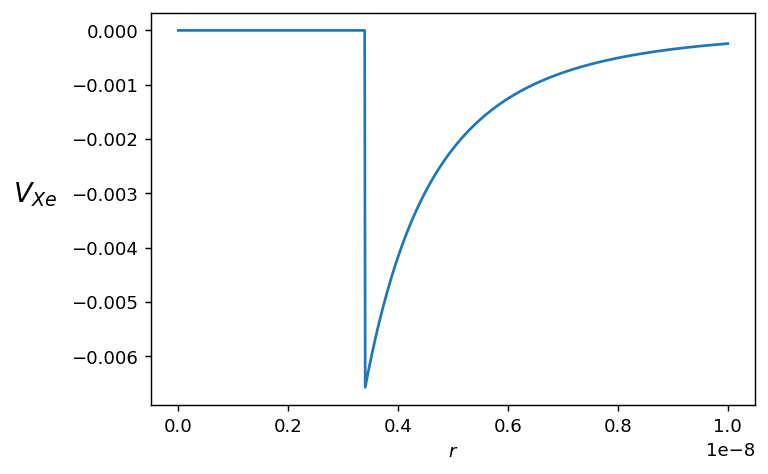

In [7]:
plt.plot(r, V_Xe(r))
ylabel =plt.ylabel(r'$V_{Xe}$', fontsize=15, labelpad=20)
ylabel.set_rotation(0)
plt.xlabel(r'$r$')
plt.savefig('V_Xe_Schmidt.png')
plt.show()

### Implementing Eq. (32)
Setting $r_0 = 1$.   
$U(r) = V(r)/U_0$ where $U_0$ is the energy scale $U_0= \hbar^2 / (2m_r r_0)^2$ (in meV).

 * You should make sure that your phase shift is converged with respect to the distance (because it is formally defined when $r>>r_0$). So you can try to plot the phase shift as a function of r for a fixed k to check this. (???)
 

In [8]:
r_0 = 1 * angstrom # screening length: [m]
U_0 = hbar**2 * meV / (2 * M_red * r_0)**2 

## solve ODE using VPA for multiple k equation (32)
def ODE_32(delta, r, k, V_0):
    top = (2 * M_red * V_Xe(r) / U_0) * (np.cos(delta * riccati_yn(0, k * r )) - np.sin(delta))**2
    ddelta_dr = -(top / k ) ######### units of hbar**(-1) ?
    return ddelta_dr

# ODEINT solver
for k_i in k:
    delta= odeint(ODE_32, 0, r, args=(k_i, v_0))
    ## print accumulation of phase shift:
    # print(delta[-1])

RuntimeError: The array return by func must be one-dimensional, but got ndim=2.